In [1]:
import tensorflow as tf
import sionna

AttributeError: jit_init_thread_state(): the LLVM backend is inactive because the LLVM shared library ("LLVM-C.dll") could not be found! Set the DRJIT_LIBLLVM_PATH environment variable to specify its path.

In [3]:
print(sionna.__version__)

0.19.1


In [4]:
import os
if os.getenv('CUDA_VISIBLE_DEVICES') is None:
    gpu_num = 0
    os.environ['CUDA_VISIBLE_DEVICES'] = f'{gpu_num}'
os.environ['TF_CPP_MIN_LOG-LEVEL'] = '3'

try:
    import sionna 
except ImportError as e:
    import os
    os.system('pip install sionna')
    import sionna
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
!nvidia-smi

Fri Jan 31 14:41:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX330         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8             N/A / ERR!  |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
#configuring to use a singel GPU
gpu = tf.config.list_logical_devices('GPU')
print('Number of gpus available :', len(gpu))
if gpu:
    gpu_num = 0 
    try :
        tf.config.set_visible_devices(gpu[gpu_num], 'GPU')
        print('only GPU number', gpu_num, 'used.')
        t.config.experimental.set_memory_growth(gpu[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of gpus available : 0


In [7]:
# seed 
sionna.config.seed = 40
import random
random.randint(0,20)
print(sionna.config.py_rng.randint(0,20))
import numpy as np
np.random.randint(0,20)
print(sionna.config.np_rng.integers(0,20))
import tensorflow as tf
tf.random.uniform(shape=[1], minval = 0, maxval=20, dtype=tf.int32)

14
11


<tf.Tensor: shape=(1,), dtype=int32, numpy=array([11])>

### AWGN - Additive White Gaussian Noise 
used for critical simulations model used in 5G communication to test and evaluate signal performance 

In [8]:
channel = sionna.channel.AWGN()

In [9]:
# defeing a complex tensor for t(x)
x = tf.constant([[0., 1.5, 1., 0.], [-1., 0., -2., 3]], dtype=tf.complex64)
print(x.shape)
print(x)

(2, 4)
tf.Tensor(
[[ 0. +0.j  1.5+0.j  1. +0.j  0. +0.j]
 [-1. +0.j  0. +0.j -2. +0.j  3. +0.j]], shape=(2, 4), dtype=complex64)


In [10]:
# implementing SNR 5dbm from enb
ebn = 15
#calculate noise variation from given enb
n = sionna.utils.ebnodb2no(ebno_db=ebn, num_bits_per_symbol=2, coderate=1)
y = channel([x,n])
print('noisy symbols are: ', y)

noisy symbols are:  tf.Tensor(
[[ 0.0702008 +0.08490686j  1.5479223 -0.05469945j  0.956845  +0.02937795j
   0.06584548-0.08964308j]
 [-0.9718475 -0.09076586j -0.12796274-0.06412427j -1.9476085 -0.17728953j
   2.8731372 +0.09909171j]], shape=(2, 4), dtype=complex64)


In [11]:
#Let us assume we want to add a CRC-24 check to 64 codewords of length 500 (e.g., different CRC per sub-carrier).
batch_size=100 # for parallelsim
num_codewords = 64 # codeword / batch
info_bit_lenght = 500 #nfo per codewords

source = sionna.utils.BinarySource() #generating random bin tensors
u = source([batch_size, num_codewords, info_bit_lenght])
print('shape of u', u.shape)
#initiallizing crc encoder wtih std complaint crc24a
encoder_crc = sionna.fec.crc.CRCEncoder('CRC24A')
decoder_crc = sionna.fec.crc.CRCDecoder(encoder_crc)

#add crc to info bits u
c = encoder_crc(u) #returns a list[c, crc_valid]
print(c.shape)
print(np.size(c.numpy()))

u_hat, crc_valid = decoder_crc(c)
print(u_hat.shape)
print(crc_valid.shape)
print(crc_valid.numpy()[0,0,0])

shape of u (100, 64, 500)
(100, 64, 524)
3353600
(100, 64, 500)
(100, 64, 1)
True


### QAM CONSTELLATION

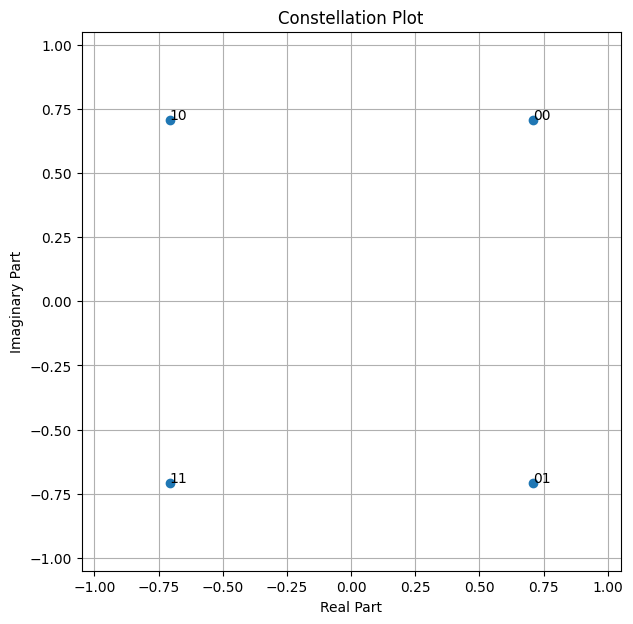

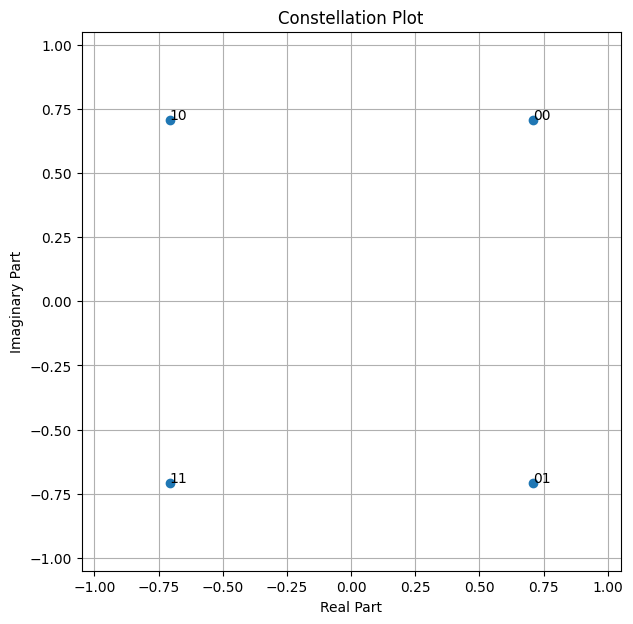

In [12]:
#4 QAM
num_bits_per_symbol = 2 #qpsk
constellation = sionna.mapping.Constellation('qam', num_bits_per_symbol)
constellation.show()

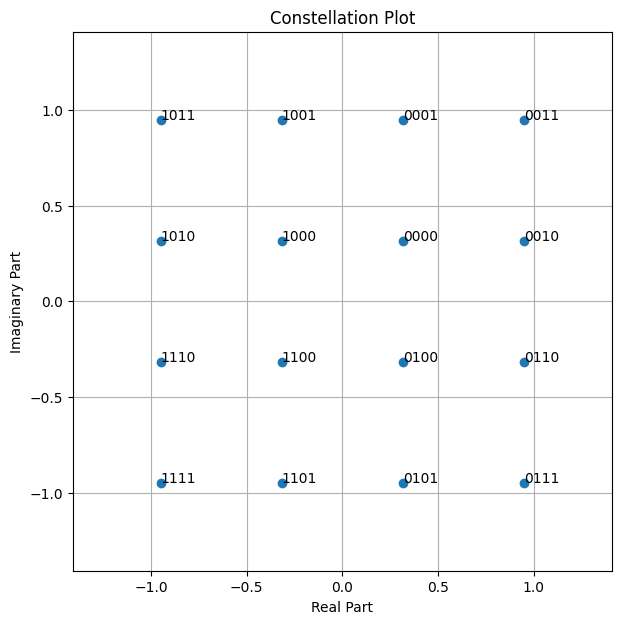

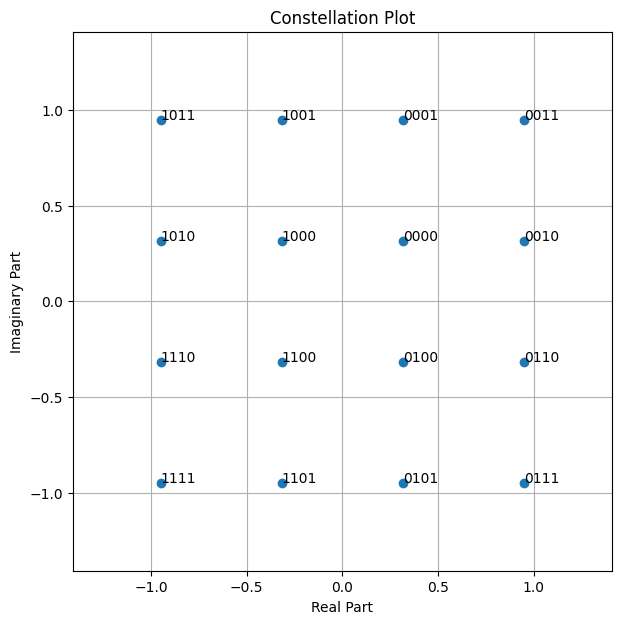

In [13]:
# 16 QAM
num_bits_per_symbol = 4 #qpsk
constellation = sionna.mapping.Constellation('qam', num_bits_per_symbol)
constellation.show()

Text(0.5, 1.0, 'QAM constellation')

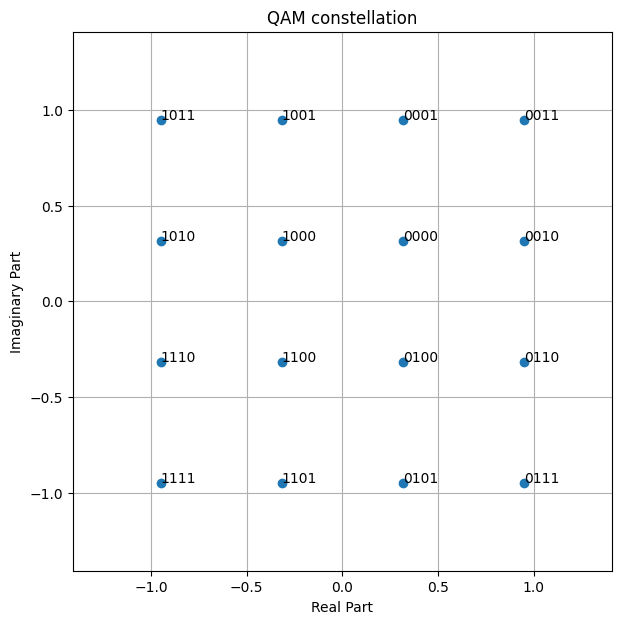

In [14]:
# MAPPING FOR CONSTELLATION
mapper = sionna.mapping.Mapper(constellation=constellation)
demapper = sionna.mapping.Demapper('app', constellation=constellation)
constellation = sionna.mapping.Constellation('qam', num_bits_per_symbol)
fig = constellation.show()
plt.title('QAM constellation')

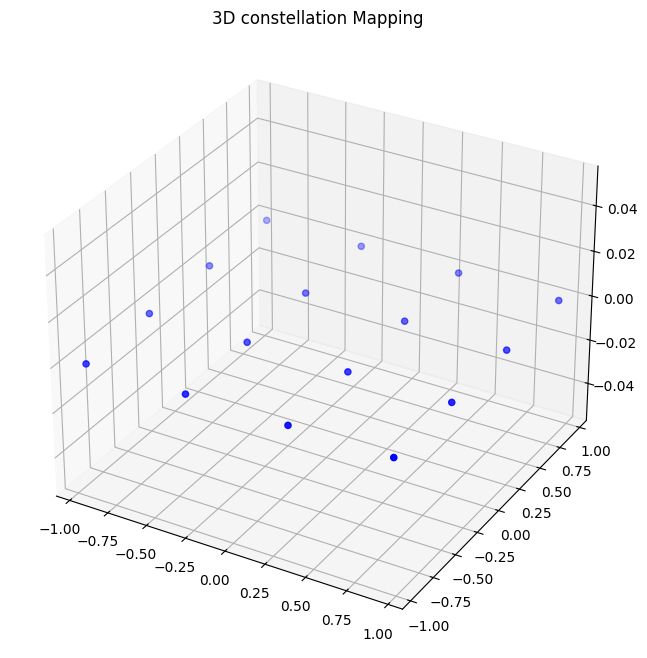

In [15]:
# scatter plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

points = constellation.points
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tf.math.real(points), tf.math.imag(points), zs=0, c='blue', marker='o')
plt.title('3D constellation Mapping')
plt.show()

In [16]:
sionna.mapping.Mapper??

Init signature:
sionna.mapping.Mapper(
    constellation_type=None,
    num_bits_per_symbol=None,
    constellation=None,
    return_indices=False,
    dtype=tf.complex64,
    **kwargs,
)
Source:        
class Mapper(Layer):
    # pylint: disable=line-too-long
    r"""
    Mapper(constellation_type=None, num_bits_per_symbol=None, constellation=None, return_indices=False, dtype=tf.complex64, **kwargs)

    Maps binary tensors to points of a constellation.

    This class defines a layer that maps a tensor of binary values
    to a tensor of points from a provided constellation.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation :  Constellation
        An ins

In [17]:
binary_source = sionna.utils.BinarySource()

In [18]:
# simulates models noise in signal transmission 
awgn_channel = sionna.channel.AWGN()

In [19]:
# noise spectral density ratio to noise spectral density ratio 
no = sionna.utils.ebnodb2no(ebno_db=10.0, num_bits_per_symbol=num_bits_per_symbol, coderate=1.0)

### we can transmitt the QAM symbols on AWGN channel 

In [20]:
batch_size = 64
bits = binary_source([batch_size, 1024])
print('shape of bits: ', bits.shape)
x = mapper(bits)
print('shape of x: ', x.shape)
y = awgn_channel([x, no])
print('shape of y: ', y.shape)
llr = demapper([y, no])
print('shape of llr: ', llr.shape)

shape of bits:  (64, 1024)
shape of x:  (64, 256)
shape of y:  (64, 256)
shape of llr:  (64, 1024)


In [21]:
# eager mode
num_samples = 8
num_symbols = int(num_samples/num_bits_per_symbol)
print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

First 8 transmitted bits: [0. 1. 0. 0. 1. 0. 1. 0.]
First 2 transmitted symbols: [ 0.32-0.32j -0.95+0.32j]
First 2 received symbols: [ 0.17-0.21j -1.2 +0.28j]
First 8 demapped llrs: [ -8.46  10.81 -23.54 -21.19  89.59 -14.28  28.8  -17.72]


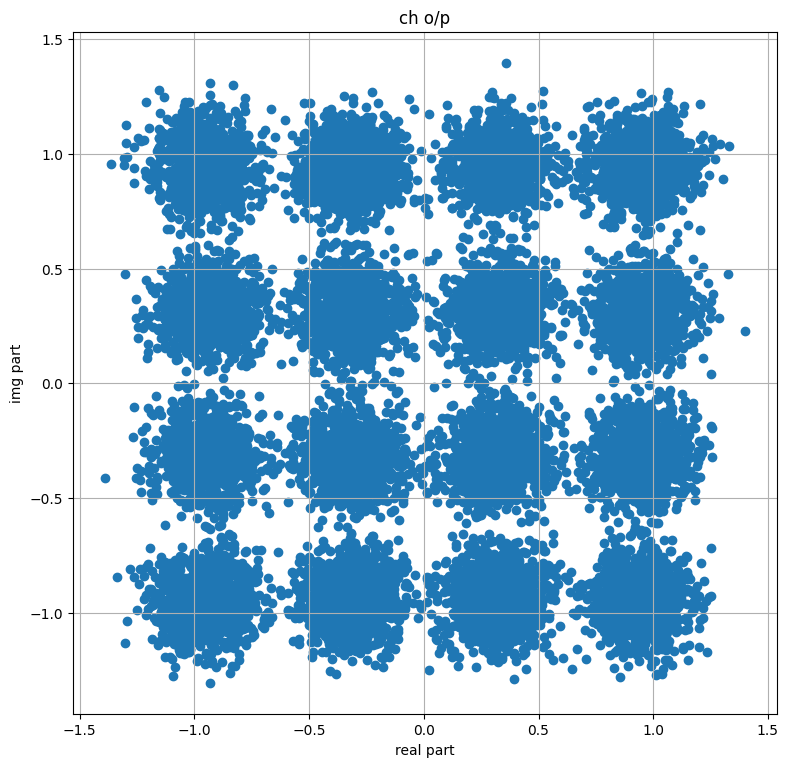

In [22]:
# noisy sample visualization
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('ch o/p')
plt.xlabel('real part')
plt.ylabel('img part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

In [23]:
import keras
from keras import layers

# COMMUNICATION SYSTEM AS KERAS MODEL 

In [24]:
'''*********''' 
class UncodedSystemAWGN(keras.Model):
    def __init__(self, num_bits_per_symbol, block_length):
        super().__init__()
        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sionna.mapping.Constellation('qam', self.num_bits_per_symbol)
        self.mapper = sionna.mapping.Mapper(constellation=self.constellation)
        self.demapper = sionna.mapping.Demapper('app', constellation = self.constellation)
        self.binary_source = sionna.utils.BinarySource()
        self.awgn_channel = sionna.channel.AWGN()
    #tf function to enable graph execution to speed up 
    def __cell__(self, batch_size, enbo_db):
        no = sionna.ebnodb(enbo_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0)
        bits = self.binary_source([batch_size, self.block_lenght]) #block lenght = 1024
        x = self.mapper(bits)
        y = self.awgn_channel([x,no])
        llr = self.demapper([y, no])
        return bits, llr

In [25]:
# instantiating model
model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=num_bits_per_symbol, block_length=1024)

In [26]:
ENB0_DB_MIN = -3.0
ENB0_DB_MAX = 5.0
BATCH_SIZE = 2000

bar_plot = sionna.utils.PlotBER('AWGN')
bar_plot.simulate(model_uncoded_awgn, ebno_dbs=np.linspace(ENB0_DB_MIN, ENB0_DB_MAX, 20),
                   batch_size = BATCH_SIZE,
                   num_target_block_errors = 100,
                   legend = 'Uncoded',
                   soft_estimates=True,
                   max_mc_iter = 100,
                   show_fig = True)
                    

ValueError: The first argument to `Layer.call` must always be passed.

In [ ]:
import tensorflow as tf
import sionna
import keras

class UncodedSystemAWGN(keras.Model):
    def __init__(self, num_bits_per_symbol, block_length):
        super().__init__()
        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sionna.mapping.Constellation('qam', self.num_bits_per_symbol)
        self.mapper = sionna.mapping.Mapper(constellation=self.constellation)
        self.demapper = sionna.mapping.Demapper('app', constellation=self.constellation)
        self.binary_source = sionna.utils.BinarySource()
        self.awgn_channel = sionna.channel.AWGN()

    # Crucial Change: Rename to call() instead of __cell__
    @tf.function
    def call(self, inputs):
        # Unpack inputs
        batch_size, ebno_db = inputs
        
        # Correct typo: block_length instead of block_lenght
        no = sionna.ebnodb(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0)
        
        # Generate bits
        bits = self.binary_source([batch_size, self.block_length])
        
        # Transmission process
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        
        # Hard decision decoding
        b_hat = tf.cast(self.demapper([y, no]) > 0, tf.int32)
        
        return bits, b_hat

# Simulation Setup
num_bits_per_symbol = 2  # Example value
ENB0_DB_MIN = -3.0
ENB0_DB_MAX = 5.0
BATCH_SIZE = 2000

# Create model instance
model_uncoded_awgn = UncodedSystemAWGN(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=1024
)

# Simulation
bar_plot = sionna.utils.PlotBER('AWGN')
bar_plot.simulate(
    model_uncoded_awgn, 
    ebno_dbs=np.linspace(ENB0_DB_MIN, ENB0_DB_MAX, 20),
    batch_size=BATCH_SIZE,
    num_target_block_errors=100,
    legend='Uncoded',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=True
)


In [27]:
import tensorflow as tf
import sionna
import keras
import numpy as np

class UncodedSystemAWGN(keras.Model):
    def __init__(self, num_bits_per_symbol, block_length):
        super().__init__()
        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sionna.mapping.Constellation('qam', self.num_bits_per_symbol)
        self.mapper = sionna.mapping.Mapper(constellation=self.constellation)
        self.demapper = sionna.mapping.Demapper('app', constellation=self.constellation)
        self.binary_source = sionna.utils.BinarySource()
        self.awgn_channel = sionna.channel.AWGN()

    # Modify to accept batch_size and ebno_db as separate arguments
    @tf.function
    def call(self, batch_size, ebno_db):
        # Noise calculation
        no = sionna.ebnodb(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0)
        
        # Generate bits
        bits = self.binary_source([batch_size, self.block_length])
        
        # Transmission process
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        
        # Hard decision decoding
        b_hat = tf.cast(self.demapper([y, no]) > 0, tf.int32)
        
        return bits, b_hat

# Simulation Setup
num_bits_per_symbol = 2  # Example value
ENB0_DB_MIN = -3.0
ENB0_DB_MAX = 5.0
BATCH_SIZE = 2000

# Create model instance
model_uncoded_awgn = UncodedSystemAWGN(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=1024
)

# Simulation
bar_plot = sionna.utils.PlotBER('AWGN')
bar_plot.simulate(
    model_uncoded_awgn, 
    ebno_dbs=np.linspace(ENB0_DB_MIN, ENB0_DB_MAX, 20),
    batch_size=BATCH_SIZE,
    num_target_block_errors=100,
    legend='Uncoded',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=True
)


AttributeError: Exception encountered when calling layer 'uncoded_system_awgn_1' (type UncodedSystemAWGN).

in user code:

    File "C:\Users\DELL\AppData\Local\Temp\ipykernel_2180\2993856948.py", line 21, in call  *
        no = sionna.ebnodb(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0)

    AttributeError: module 'sionna' has no attribute 'ebnodb'


Call arguments received by layer 'uncoded_system_awgn_1' (type UncodedSystemAWGN):
  • batch_size=tf.Tensor(shape=(), dtype=int32)
  • ebno_db=tf.Tensor(shape=(), dtype=float32)

# DISCOVERY OF SIONNA

In [28]:
import sionna
import os
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
!nvidia-smi #restricting the cpu/gpu to single one

ERROR: Option #restricting is not recognized. Please run 'nvidia-smi -h'.



In [30]:
### this inherently parallelizes simulations via batching each, also we are intended to transmitt some symbols over AWGN channel 
channel = sionna.channel.AWGN()#adding gaussian noise to some given values of x

In [31]:
# complex value to be transmitted
x = tf.constant([[0., 1.5, 1., 0.],[-1., 0., -2., 3]], dtype=tf.complex64)
print(x.shape, x)

(2, 4) tf.Tensor(
[[ 0. +0.j  1.5+0.j  1. +0.j  0. +0.j]
 [-1. +0.j  0. +0.j -2. +0.j  3. +0.j]], shape=(2, 4), dtype=complex64)


In [32]:
# signal to noise ratio of 5db 
ebno_db = 5
no = sionna.utils.ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=2, coderate=1)
y = channel([x, no])
print('Noisy symbols are: ', y)

Noisy symbols are:  tf.Tensor(
[[ 0.330723  +0.12035984j  1.8807869 -0.00232177j  1.1580107 -0.1991366j
   0.05415234-0.26801592j]
 [-1.1800985 -0.29292455j -0.09051878-0.47346517j -1.7540007 -0.28785327j
   2.780153  -0.21055265j]], shape=(2, 4), dtype=complex64)


### batches and multidim tensors

In [33]:
batch_size = 100
num_codewords = 64
info_bit_length = 500
source = sionna.utils.BinarySource()
u = source([batch_size, num_codewords, info_bit_length])
print(u.shape)

encoder_crc = sionna.fec.crc.CRCEncoder('CRC24A')
decoder_crc = sionna.fec.crc.CRCDecoder(encoder_crc)

c = encoder_crc(u)
print(c.shape)
print(np.size(c.numpy()))

u_cap, crc_valid = decoder_crc(c)
print(u_cap.shape, crc_valid.shape, crc_valid.numpy()[0,0,0])


(100, 64, 500)
(100, 64, 524)
3353600
(100, 64, 500) (100, 64, 1) True


In [34]:
# for 5 seperate simulations 5 dims can be added 
num_users = 5
u = source([batch_size, num_users, num_codewords, info_bit_lenght])
c = encoder_crc(u)
print(c.shape)
print(np.size(c.numpy()))

(100, 5, 64, 524)
16768000


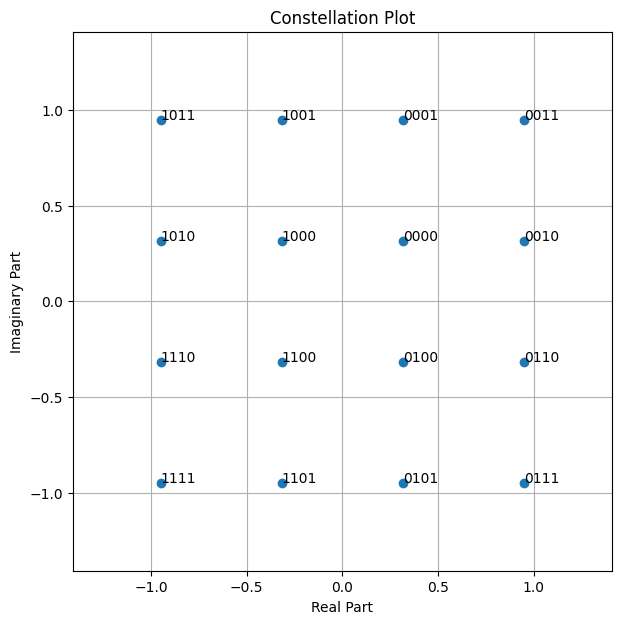

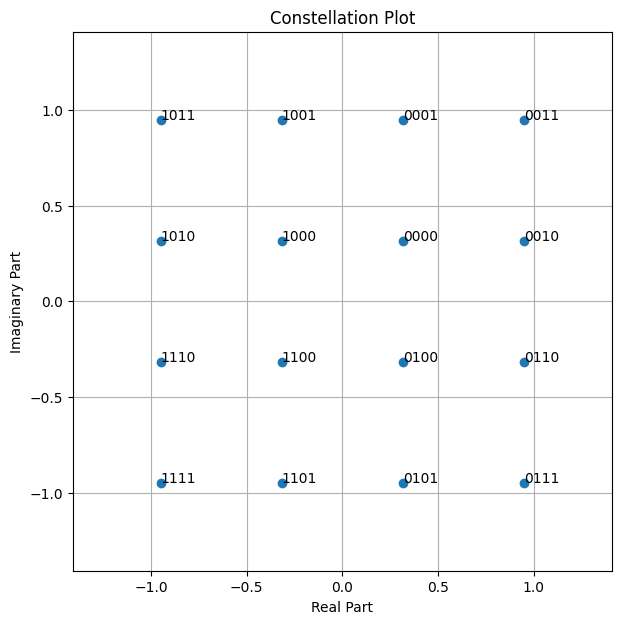

In [35]:
#16 QAM constellation 
constellation = sionna.mapping.Constellation('qam', num_bits_per_symbol=4)
constellation.show()

### 1ST Link level simulation 

In [36]:
n_ldpc = 500
k_ldpc = 250
coderate = k_ldpc/n_ldpc
num_bits_per_symbol = 4

In [37]:
demapping_method = 'app'
ldpc_cn_type = 'boxplus'
binary_source = sionna.utils.BinarySource()
encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(k_ldpc, n_ldpc) #add redundant data
constellation = sionna.mapping